## Imports

In [2]:
import copy
import glob
import importlib
import itertools
import math
import os
import random
import shutil
import sys
from math import degrees, pi, radians
from os.path import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import SimpleITK as sitk
import skimage.feature as skf
from skimage.morphology import ball

import cnn_builder as cbuild
import config
import lipiodol_methods as lm
import niftiutils.helper_fxns as hf
import niftiutils.masks as masks
import niftiutils.registration as reg
import niftiutils.transforms as tr
from config import Config

%matplotlib inline

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [64]:
importlib.reload(config)
C = config.Config()

In [4]:
img_dir = "D:\\Lipiodol\\Images all"
seg_dir = "D:\\Lipiodol\\Images extracted and segmentations"
target_dir = "D:\\Lipiodol\\Data"

## Pattern analysis

In [32]:
patients = [basename(fn) for fn in glob.glob(join(target_dir,"*"))]
num_patients = len(patients)

In [315]:
patient_id = "PK-08"
importlib.reload(lm)
paths = lm.get_paths(patient_id, target_dir, check_valid=False)

mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
mribl_art_path, mribl_pre_path, \
mribl_tumor_mask_path, mribl_liver_mask_path, \
mribl_enh_mask_path, mribl_nec_mask_path, \
mri30d_art_path, mri30d_pre_path, \
mri30d_tumor_mask_path, mri30d_liver_mask_path, \
mri30d_enh_mask_path, mri30d_nec_mask_path, \
ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
midlip_mask_path, ball_midlip_mask_path, \
highlip_mask_path, ball_highlip_mask_path = paths

### Validate HU scale

In [132]:
Bins = list(range(0,501,10))
LxL = np.zeros((len(Bins),len(Bins)), int)

In [153]:
def otsu_2d(img, ignore_below=0):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(img.shape[2]):
                if np.isnan(img[i,j,k]):
                    continue
                #I = int(min(round(img[i,j,k]/10), len(Bins)-1))
                
                neighborhood = [slice(max(i-2,0),i+2), slice(max(j-2,0),j+2), slice(max(k-1,0),k+1)]
                #J = int(min(round(np.mean(img[neighborhood])/10), len(Bins)-1))
                n = np.count_nonzero(~np.isnan(img[neighborhood]))
                voxel_ints_2d.append([img[i,j,k], (np.nansum(img[neighborhood])-img[i,j,k])/(n-1)])
                #LxL[I,J] += 1
        print(n)

In [344]:
#voxel_ints = []
#voxel_ints_2d = []
#otsus = []
#LI = []
#ISO = []
#YEN = []
KM = []
for fn in glob.glob(join(target_dir,"*")):
    patient_id = basename(fn)
    paths = lm.get_paths(patient_id, target_dir)

    mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
    mribl_art_path, mribl_pre_path, \
    mribl_tumor_mask_path, mribl_liver_mask_path, \
    mribl_enh_mask_path, mribl_nec_mask_path, \
    mri30d_art_path, mri30d_pre_path, \
    mri30d_tumor_mask_path, mri30d_liver_mask_path, \
    mri30d_enh_mask_path, mri30d_nec_mask_path, \
    ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
    ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
    midlip_mask_path, ball_midlip_mask_path, \
    highlip_mask_path, ball_highlip_mask_path = paths
    
    img,D = hf.nii_load(ct24_path)
    M = masks.get_mask(ct24_tumor_mask_path, D, img.shape)[0]
    img = img*M/M.max()
    
    km=sklearn.cluster.KMeans(2, n_jobs=2)#, algorithm="full")
    km.fit(img[img > 100].reshape(-1,1))
    KM.append(km.cluster_centers_)
    
    #LI.append(filters.threshold_li(img[img > 100]))
    #ISO.append(filters.threshold_isodata(img[img > 100]))
    #YEN.append(filters.threshold_yen(img[img > 100]))
    #otsus.append(filters.threshold_otsu(img[img > 100]))
    
    #voxel_ints.append(img[img>0])
    
    #img[img <= 0] = np.nan
    #img = hf.crop_nonzero(img)[0]
    #otsu_2d(img)

In [ ]:
KM

In [341]:
filters.threshold_mean(LI)

205.5531766545207

In [ ]:
plt.hist(LI,30)

In [342]:
np.percentile(LI, 100/3), np.percentile(LI, 200/3)

(159.8438546709155, 215.4651656444234)

In [169]:
V = np.stack(voxel_ints_2d, 0)
W = V[~np.isnan(V)]
W = W.reshape((-1,2))

In [83]:
import sklearn.cluster

In [200]:
W.shape

(3748793, 2)

In [201]:
V = W[W[:,0]>100]

In [212]:
V.shape

(1188295, 2)

In [221]:
np.save("D:\\W.npy", W)

In [264]:
KM=sklearn.cluster.KMeans(2, n_jobs=2)#, algorithm="full")
KM.fit(np.array(otsus).reshape(-1,1))
KM.cluster_centers_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=2, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [237]:
np.percentile(V[:,0],33)

132.0

In [236]:
np.percentile(V[:,0],67)

184.57746478873239

In [233]:
np.mean(KM.cluster_centers_[:2]), np.mean(KM.cluster_centers_[[0,2]])

(211.89185481710794, 317.71118035792426)

In [299]:
ZZ=np.stack([list(range(100,500,10)), list(range(100,500,10))], -1)

In [309]:
from sklearn.cluster import MeanShift
MS = MeanShift(min_bin_freq=1, cluster_all=True, n_jobs=2)

In [310]:
MS.fit(np.array(otsus).reshape(-1, 1))

MeanShift(bandwidth=None, bin_seeding=False, cluster_all=True, min_bin_freq=1,
     n_jobs=2, seeds=None)

In [311]:
MS.cluster_centers_

array([[169.99059606],
       [281.62555804],
       [396.90169271],
       [571.9921875 ],
       [485.10546875]])

In [289]:
V[:,0].size//10

118829

In [329]:
[(V[:,0] > x[0]).sum()/V[:,0].size for x in KM.cluster_centers_]

[1.0, 0.5239010515065703, 0.26654324052529044, 0.1406048161441393]

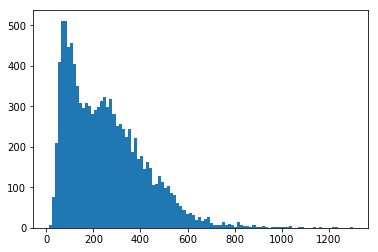

In [107]:
H=plt.hist(voxel_ints,bins=100)

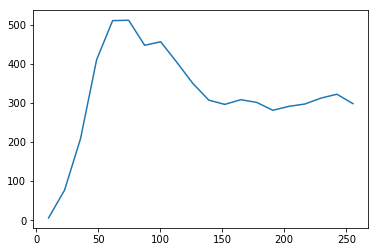

In [108]:
plt.plot(H[1][:-81],H[0][:-80])

In [103]:
voxel_ints = []
for fn in glob.glob(join(target_dir,"*")):
    patient_id = basename(fn)
    paths = lm.get_paths(patient_id, target_dir)

    mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
    mribl_art_path, mribl_pre_path, \
    mribl_tumor_mask_path, mribl_liver_mask_path, \
    mribl_enh_mask_path, mribl_nec_mask_path, \
    mri30d_art_path, mri30d_pre_path, \
    mri30d_tumor_mask_path, mri30d_liver_mask_path, \
    mri30d_enh_mask_path, mri30d_nec_mask_path, \
    ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
    ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
    midlip_mask_path, ball_midlip_mask_path, \
    highlip_mask_path, ball_highlip_mask_path = paths
    
    img,D = hf.nii_load(ct24_path)
    M = masks.get_mask(ct24_tumor_mask_path, D, img.shape)[0]
    img = img*M/M.max()
    voxel_ints.append(img[img>0])
    break

In [ ]:

ctbl_

img,D = hf.nii_load(ct24_path)
M = masks.get_mask(ct24_tumor_mask_path, D, img.shape)[0]
img = img*M/M.max()
voxel_ints.append(img[img>0])

### Build DataFrame

pattern_df = pd.DataFrame(columns=pattern_feat_cols)
lipresp_df = pd.DataFrame(columns=lipresp_cols)

for name in lipresp_cols:
    df.loc[:,"peripheral_coverage%"]=pd.Series(np.random.randn(len(df)), index=df.index)

In [428]:
pattern_feat_cols = ["enhancing_vol%", "lipcoverage_vol%",
                       "rim_enhancing%", "rim_lipiodol%",
                       "mribl_contrast", "mribl_variance", "mribl_homog",
                       "lip_contrast", "lip_variance", "lip_homog",
                       "peripheral_coverage%"]

lipresp_cols = []
for name in itertools.product(["base_", "low_", "mid_", "high_"], ["resp%", "prog%", "bl_enh%", "30d_enh%"]):
    lipresp_cols.append(name[0]+name[1])
    
# resp% is the % of BL enhancing tumor that becomes necrotic within this lipiodol range
# prog% is the % of BL necrotic tumor that becomes enhancing within this lipiodol range
# bl_enh% is the % of tumor within this lipiodol range that is enhancing on BL MR
# 30d_enh% is the % of tumor within this lipiodol range that is enhancing on 30d MR

In [430]:
importlib.reload(config)
C = config.Config()

In [8]:
pattern_df = pd.read_excel(C.data_xls_path, "Patterns")
lipresp_df = pd.read_excel(C.data_xls_path, "Lip-Resp")
vasc_depo_df = pd.read_excel(C.data_xls_path, "Vascularization-Deposition")
depo_resp_df = pd.read_excel(C.data_xls_path, "Deposition-Response")
vasc_depo_df_binary = pd.read_excel(C.data_xls_path, "Vasc-Depo-binary")
depo_resp_df_binary = pd.read_excel(C.data_xls_path, "Depo-Resp-binary")

In [7]:
writer = pd.ExcelWriter(C.data_xls_path)

In [62]:
[basename(fn) for fn in glob.glob(join(target_dir,"*"))].index('PK-02')

27

In [62]:
importlib.reload(lm)
for fn in glob.glob(join(target_dir,"*")):
    patient_id = basename(fn)
    paths = lm.get_paths(patient_id, target_dir)

    mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
    mribl_art_path, mribl_pre_path, \
    mribl_tumor_mask_path, mribl_liver_mask_path, \
    mribl_enh_mask_path, mribl_nec_mask_path, \
    mri30d_art_path, mri30d_pre_path, \
    mri30d_tumor_mask_path, mri30d_liver_mask_path, \
    mri30d_enh_mask_path, mri30d_nec_mask_path, \
    ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
    ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
    midlip_mask_path, ball_midlip_mask_path, \
    highlip_mask_path, ball_highlip_mask_path = paths

    ball_IV = lm.get_avg_ball_intensity(ball_ct24_path, ball_mask_path)
    row=[]
    #row = lm.get_rim_coverage(row, masks.get_mask(ball_mribl_enh_mask_path)[0] + 1, ball_mask_path, 1.5)
    row = lm.get_rim_coverage(row, hf.nii_load(ball_ct24_path)[0], ball_mask_path, max(ball_IV,150))
    
    pattern_df.loc[patient_id, ["rim_enhancing%", "rim_lipiodol%"]] = row

In [16]:
patient_id = "BM-27"
pattern_df.loc[patient_id] = lm.get_row_entry(patient_id, target_dir)

In [31]:
pattern_df.loc[pattern_df["rim_lipiodol%"]==0, "rim_lipiodol%"] = np.nan

In [19]:
importlib.reload(lm)
for fn in glob.glob(join(target_dir,"*")):
    patient_id = basename(fn)
    #print(patient_id)
    #lm.spherize(patient_id, target_dir)
    pattern_df.loc[patient_id] = lm.get_row_entry(patient_id, target_dir)

In [438]:
importlib.reload(lm)
for fn in glob.glob(join(target_dir,"*")):
    patient_id = basename(fn)
    lips = lm.enhancing_to_nec(patient_id, target_dir, liplvls)
    lipresp_df.loc[ix] = np.round(np.array(lips)*100,2).flatten()

C:\Users\Clinton\Documents\Lipiodol\lipiodol_methods.py:136: RuntimeWarning: invalid value encountered in long_scalars
  samples = np.round(samples).astype(int)


In [512]:
pattern_df.to_excel(writer, "Patterns")
lipresp_df.to_excel(writer, "Lip-Resp")
#writer.save()

## Correlating Vasc/Lip Deposition

In [20]:
liplvls=[0,100,150,200]#,250,300]#list(range(0,401,10))

In [34]:
importlib.reload(lm)
vasc_depo_df = pd.DataFrame(columns=liplvls)
for patient_id in patients:
    vasc_depo_df.loc[patient_id] = lm.vascular_to_deposition(patient_id, target_dir, liplvls, exclude_small=True)

In [35]:
df=vasc_depo_df.dropna()

In [548]:
importlib.reload(lm)
depo_resp_df = pd.DataFrame(columns=liplvls)
for patient_id in patients:
    depo_resp_df.loc[patient_id] = lm.lip_to_response(patient_id, target_dir, liplvls, exclude_small=False)

df = depo_resp_df.dropna()

In [ ]:
print([df[i].mean() for i in liplvls])

[1-df[i].mean() for i in liplvls]

[x/(1-x) for x in [0.47604184262689564,
 0.3884550297888517,
 0.3352322775428981,
 0.2986988994268489]]

In [ ]:
[1-df[i].mean() for i in liplvls]

In [ ]:
print([df[i].mean() for i in liplvls])

print(np.nanmean(depo_resp_df[0]),
np.nanmean(depo_resp_df[100]),
np.nanmean(depo_resp_df[150]),
np.nanmean(depo_resp_df[200]))

In [87]:
pattern_gtruth_df = pd.read_excel(r"D:\Lipiodol\Results\Lipiodol Patterns.xlsx", index_col=0)

In [88]:
joint_df = pd.concat([vasc_depo_df, pattern_gtruth_df], axis=1, join='inner')

In [89]:
joint_df.columns

Index([                   0,                  100,                  150,
                        200,        'homogeneous',      'heterogeneous',
                      'rim',     'central recess', 'central deposition',
          'penumbra/margin',           'comments'],
      dtype='object')

In [116]:
DF=joint_df.dropna(subset=["heterogeneous"], axis=0)
subset_df = DF.loc[DF["heterogeneous"].str.contains("yes"), liplvls+["heterogeneous"]]
#subset_df = DF.loc[DF["penumbra/margin"]!="no", liplvls+["penumbra/margin"]]
subset_df

,0,100,150,200,heterogeneous
BM-01,0.979969,0.972471,0.989408,0.989211,yes
BM-02,0.213386,0.338595,0.488734,0.349517,yes scattered
BM-03,0.053209,0.034601,0.019784,0.016724,yes
BM-05,0.776399,0.714221,0.620473,0.560444,yes
BM-06,0.484110,0.737965,0.766199,0.769996,yes
BM-07,0.381427,0.579057,0.656548,0.721992,yes
BM-09,0.373079,0.439064,0.683052,0.738784,yes
BM-10,0.674982,0.797312,0.918109,0.938735,yes
BM-12,0.435976,0.563419,0.738764,0.899583,yes
BM-19,0.807288,0.864336,0.747795,0.843143,yes


In [117]:
subset_df.index

Index(['BM-01', 'BM-02', 'BM-03', 'BM-05', 'BM-06', 'BM-07', 'BM-09', 'BM-10',
       'BM-12', 'BM-19', 'BM-23', 'BM-24', 'BM-26', 'BM-27', 'BM-29', 'BM-30',
       'BM-31', 'BM-32', 'BM-36', 'BM-37', 'BM-39', 'PK-02', 'PK-05', 'PK-07',
       'PK-08'],
      dtype='object')

RIM: "BM-07", "BM-30", "BM-32", "BM-37"
Homogeneous: "BM-18", "BM-25", "BM-39", "PK-03", "PK-06"
Heterogeneous: "BM-18", "BM-25", "BM-39", "PK-03", "PK-06"
Central deposition: 'BM-18', 'BM-23', 'BM-25', 'BM-31', 'BM-32', 'BM-39', 'PK-03', 'PK-08'
Central recess: 'BM-01', 'BM-07', 'BM-12', 'BM-19', 'BM-24', 'BM-30', 'BM-36', 'PK-02', 'PK-05'
Margin: 'BM-30', 'BM-32', 'BM-36', 'BM-37', 'BM-39', 'PK-02', 'PK-03', 'PK-05'

In [114]:
len(['BM-01', 'BM-07', 'BM-12', 'BM-19', 'BM-24', 'BM-30', 'BM-36', 'PK-02', 'PK-05'])

9

In [120]:
len(subset_df)

25

In [118]:
subset_df = joint_df.loc[['BM-01', 'BM-02', 'BM-03', 'BM-05', 'BM-06', 'BM-07', 'BM-09', 'BM-10',
       'BM-12', 'BM-19', 'BM-23', 'BM-24', 'BM-26', 'BM-27', 'BM-29', 'BM-30',
       'BM-31', 'BM-32', 'BM-36', 'BM-37', 'BM-39', 'PK-02', 'PK-05', 'PK-07',
       'PK-08'], [0,1,2,3]]
subset_df

,0,100,150,200
BM-01,0.979969,0.972471,0.989408,0.989211
BM-02,0.213386,0.338595,0.488734,0.349517
BM-03,0.053209,0.034601,0.019784,0.016724
BM-05,0.776399,0.714221,0.620473,0.560444
BM-06,0.484110,0.737965,0.766199,0.769996
BM-07,0.381427,0.579057,0.656548,0.721992
BM-09,0.373079,0.439064,0.683052,0.738784
BM-10,0.674982,0.797312,0.918109,0.938735
BM-12,0.435976,0.563419,0.738764,0.899583
BM-19,0.807288,0.864336,0.747795,0.843143


In [119]:
#subset_df.mean().values
subset_df.dropna().mean().values

array([0.49861879, 0.54283119, 0.60239339, 0.64819033])

In [47]:
print(np.mean(subset_df[150]), np.mean(subset_df[200]))

0.4725199969765699 0.7846028172462818


In [514]:
vasc_depo_df.to_excel(writer, "Vascularization-Deposition")
depo_resp_df.to_excel(writer, "Deposition-Response")
writer.save()

In [ ]:
vasc_depo_df

In [515]:
liplvls=[0,100]#,250,300]#list(range(0,401,10))

In [516]:
importlib.reload(lm)
vasc_depo_df_binary = pd.DataFrame(columns=liplvls)
for patient_id in lipresp_df.index:
    vasc_depo_df_binary.loc[patient_id] = lm.vascular_to_deposition(patient_id, target_dir, liplvls, exclude_small=True)

In [517]:
depo_resp_df_binary = pd.DataFrame(columns=liplvls)
for patient_id in lipresp_df.index:
    depo_resp_df_binary.loc[patient_id] = lm.lip_to_response(patient_id, target_dir, liplvls, exclude_small=False)

In [518]:
vasc_depo_df_binary.to_excel(writer, "Vasc-Depo-binary")
depo_resp_df_binary.to_excel(writer, "Depo-Resp-binary")
writer.save()

### T-Test

In [522]:
scipy.stats.ttest_1samp((vasc_depo_df_binary[100]-vasc_depo_df_binary[0]).dropna(), 0)

Ttest_1sampResult(statistic=2.3802691829515616, pvalue=0.025971980984010247)

In [523]:
scipy.stats.ttest_1samp((vasc_depo_df[150]-vasc_depo_df[100]).dropna(), 0)

Ttest_1sampResult(statistic=2.428121152144739, pvalue=0.024249353783670376)

In [524]:
scipy.stats.ttest_1samp((vasc_depo_df[200]-vasc_depo_df[150]).dropna(), 0)

Ttest_1sampResult(statistic=2.7092952234597485, pvalue=0.013907459079104805)

In [525]:
scipy.stats.ttest_1samp((depo_resp_df_binary[100]-depo_resp_df_binary[0]).dropna(), 0)

Ttest_1sampResult(statistic=3.492729013676934, pvalue=0.0015538515664505574)

In [533]:
scipy.stats.ttest_1samp((depo_resp_df[150]-depo_resp_df[100]).dropna(), 0)

Ttest_1sampResult(statistic=1.2250109889424856, pvalue=0.2348033858355313)

In [534]:
scipy.stats.ttest_1samp((depo_resp_df[200]-depo_resp_df[150]).dropna(), 0)

Ttest_1sampResult(statistic=2.800068905160147, pvalue=0.011421953792365588)

## Create Ranked DICOMs

In [15]:
importlib.reload(lm)
lm.write_ranked_imgs(pattern_df, target_dir, "lipcoverage_vol%", "ct24_path", join(C.ranking_dir, "sparsity_ranking_ct24"),
                  False, "ct24_tumor_mask_path", "ct")
lm.write_ranked_imgs(pattern_df, target_dir, "enhancing_vol%", "mribl_art_path", join(C.ranking_dir, "sparsity_ranking_mrbl"),
                  False, "mribl_tumor_mask_path")

# make pointers instead?
lm.write_ranked_imgs(pattern_df, target_dir, "rim_lipiodol%", "ct24_path", join(C.ranking_dir, "rim_ranking_ct24"),
                  False, "ct24_tumor_mask_path", "ct")
lm.write_ranked_imgs(pattern_df, target_dir, "rim_enhancing%", "mribl_art_path", join(C.ranking_dir, "rim_ranking_mrbl"),
                  False, "mribl_tumor_mask_path")

lm.write_ranked_imgs(pattern_df, target_dir, "lip_homog", "ct24_path", join(C.ranking_dir, "homogen_ranking_ct24"),
                  False, "ct24_tumor_mask_path", window="ct")
lm.write_ranked_imgs(pattern_df, target_dir, "mribl_homog", "mribl_art_path", join(C.ranking_dir, "homogen_ranking_mrbl"),
                  False, "mribl_tumor_mask_path")

In [63]:
lm.write_ranked_imgs(pattern_df.dropna(0,subset=["rim_lipiodol%"]), target_dir, "rim_lipiodol%", "ct24_path", join(C.ranking_dir, "rim_ranking_ct24"),
                  False, "ct24_tumor_mask_path", "ct")
#lm.write_ranked_imgs(pattern_df.dropna(0,subset=["rim_lipiodol%"]), target_dir, "rim_enhancing%", "mribl_art_path", join(C.ranking_dir, "rim_ranking_mrbl"),
#                  False, "mribl_tumor_mask_path")

In [17]:
lm.write_ranked_imgs(pattern_df, target_dir, "peripheral_coverage%", "ct24_path", join(C.ranking_dir, "penumbra_ranking_ct24"),
                  False, "ct24_tumor_mask_path", "ct")

In [141]:
masks.create_dcm_with_masks(ball_ct24_path, [ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path],
                            save_dir, overwrite=True, window="ct")

## Tumor Mask Screenshots

In [ ]:
importlib.reload(lm)
for fn in glob.glob(join(target_dir,"*")):
    patient_id = basename(fn)
    paths = lm.get_paths(patient_id, target_dir)

    mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
    mribl_art_path, mribl_pre_path, \
    mribl_tumor_mask_path, mribl_liver_mask_path, \
    mribl_enh_mask_path, mribl_nec_mask_path, \
    mri30d_art_path, mri30d_pre_path, \
    mri30d_tumor_mask_path, mri30d_liver_mask_path, \
    mri30d_enh_mask_path, mri30d_nec_mask_path, \
    ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
    ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
    midlip_mask_path, ball_midlip_mask_path, \
    highlip_mask_path, ball_highlip_mask_path = paths

    lm.draw_unreg_fig(mribl_art_path, mribl_tumor_mask_path, join(C.png_dir, patient_id, "BL MR"), 'b', 'mr')
    lm.draw_unreg_fig(mri30d_art_path, mri30d_tumor_mask_path, join(C.png_dir, patient_id, "30d MR"), 'r', 'mr')
    lm.draw_unreg_fig(ct24_path, ct24_tumor_mask_path, join(C.png_dir, patient_id, "24h CT"), 'g', 'ct')

In [ ]:
patient_id = "BM-20"
paths = lm.get_paths(patient_id, target_dir)

mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
mribl_art_path, mribl_pre_path, \
mribl_tumor_mask_path, mribl_liver_mask_path, \
mribl_enh_mask_path, mribl_nec_mask_path, \
mri30d_art_path, mri30d_pre_path, \
mri30d_tumor_mask_path, mri30d_liver_mask_path, \
mri30d_enh_mask_path, mri30d_nec_mask_path, \
ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
midlip_mask_path, ball_midlip_mask_path, \
highlip_mask_path, ball_highlip_mask_path = paths
masks.(mribl_art_path, mribl_liver_mask_path, join(C.png_dir, patient_id, "BL MR"), 'b', 'mr')

In [ ]:
lm.draw_reg_fig(ball_mribl_path, ball_mribl_enh_mask_path, join(C.fig_dir, patient_id, "MRIBL"), 'b', 'mr')
lm.draw_reg_fig(ball_mri30d_path, ball_mri30d_enh_mask_path, "D:\\Lipiodol\\Figures\\MRI30d", 'r', 'mr')
lm.draw_reg_fig(ball_ct24_path, ball_highlip_mask_path, "D:\\Lipiodol\\Figures\\Lip", 'g', 'ct')

In [ ]:
# Figure for 24h CT
img,_ = hf.nii_load(ball_ct24_path)
blmask,_ = masks.get_mask(ball_mribl_enh_mask_path)
fumask,_ = masks.get_mask(ball_mri30d_enh_mask_path)

for sl in range(img.shape[-1]//4,img.shape[-1]*3//4,img.shape[-1]//12):
    plt.close()
    plt.imshow(img[...,sl], cmap='gray', vmin=30, vmax=250)
    FU=plt.contour(fumask[:,:,sl], colors='r', alpha=.4)
    plt.contour(blmask[:,:,sl], colors='b', alpha=.4)
    plt.contourf(fumask[:,:,sl], colors=[(0,0,0,0)]*6+[(1,0,0,.2)]) #look at the length of FU.allsegs
    plt.contourf(blmask[:,:,sl], colors=[(0,0,0,0)]*6+[(0,0,1,.2)])
    plt.axis('off')
    plt.savefig("D:\\Lipiodol\\Figures\\24hCT_%d.png" % sl, dpi=100, bbox_inches='tight')

## Extra

IVs = get_intensity_section(ball_ct24_path, ball_mask_path, params)
            if highest_I_V < I_V:
                best_params = params
                highest_I_V = I_V
                print(best_params)
theta1_best, phi1_best, dtheta_best, dz_best = best_params

In [ ]:
ball_IV = get_avg_ball_intensity(ball_ct24_path, ball_mask_path)
core_IV = get_avg_core_intensity(ball_ct24_path, ball_mask_path)

In [303]:
ball_IV, core_IV

(197.83461276161094, 209.89937589866474)

In [ ]:
importlib.reload(lm)
IVs = lm.calc_intensity_shells_angles(hf.nii_load(ball_ct24_path)[0], ball_mask_path)
IVs[IVs==0] = np.nan

samples = lm.fibonacci_sphere(2500, True, randomize=True)
samples = np.round(samples).astype(int)
s0 = samples[:,0]
s1 = samples[:,1]
for i in range(IVs.shape[-1]):
    print(np.nanmean(IVs[s0,s1,i]))

In [388]:
loopIVs = np.tile(IVs[:-1,:-1,:], (2,2,1))
loopIVs[180:,:,:] = np.nan

In [ ]:
for dtheta in range(30,180,20):
    print(dtheta)
    best_IV = core_IV
    worst_IV = core_IV
    for theta in range(0,180,20):
        for phi in range(180,480,20):
            for shell1 in range(4):
                for shell2 in range(shell1+1,5):
                    IV = np.nanmean(loopIVs[max(theta-dtheta,0) : theta+dtheta, phi-dtheta : phi+dtheta, shell1:shell2])
                    params = theta, phi % 360, shell1, shell2
                    if best_IV < IV:
                        best_params = params
                        best_IV = IV
                        
            IV = np.nanmean(loopIVs[max(theta-dtheta,0) : theta+dtheta, phi-dtheta : phi+dtheta, :5])
            params = theta, phi % 360
            if worst_IV > IV:
                worst_params = params
                worst_IV = IV
                
    print(best_params, round(best_IV,1))
    print(worst_params, round(worst_IV,1))

In [ ]:
importlib.reload(lm)
enhmask_density = lm.calc_intensity_shells_angles(masks.get_mask(ball_mribl_enh_mask_path)[0]+1, ball_mask_path)

enhmask_density = enhmask_density[...,:5]
enhmask_density[enhmask_density==0] = np.nan

samples = fibonacci_sphere(2500, True, randomize=True)
samples = np.round(samples).astype(int)
s0 = samples[:,0]
s1 = samples[:,1]
for i in range(enhmask_density.shape[-1]):
    print(np.nanmean(enhmask_density[s0,s1,i]))

In [ ]:
importlib.reload(lm)
enhmask_density = lm.calc_intensity_shells_angles(masks.get_mask(ball_mri30d_enh_mask_path)[0]+1, ball_mask_path)

enhmask_density = enhmask_density[...,:5]
enhmask_density[enhmask_density==0] = np.nan

samples = fibonacci_sphere(2500, True, randomize=True)
samples = np.round(samples).astype(int)
s0 = samples[:,0]
s1 = samples[:,1]
for i in range(enhmask_density.shape[-1]):
    print(np.nanmean(enhmask_density[s0,s1,i]))

In [ ]:
for i in range(enhmask_density.shape[-1]):
    print(np.nanmean(enhmask_density[s0,s1,i]))

In [ ]:
enhmask_density =

In [ ]:
conv_rate = np.zeros((181,360))